### Check the original voxel spacings of the image from tiff files

In [ ]:
"""Ver very important code to get voxel spacing from tiff metadata

This is the one. Don't care about the spacings in segmentation files"""


image = "/Users/dbattagodage/Desktop/Datasets/NFN1ICD/E9.5/WIF#12 NFN1ICD 172 25ps WT scan/C3-WIF#12 NFN1ICD 172 25ps WT scan_Myo.tif"
# print metadata

import tifffile

with tifffile.TiffFile(image) as tif:
    # Get metadata dictionary
    metadata = tif.imagej_metadata  # if saved via ImageJ/Fiji
    tags = tif.pages[0].tags
    # Sometimes stored in imagej_metadata
    if metadata and 'spacing' in metadata:
        z_spacing = metadata['spacing']  # µm
    if metadata and 'unit' in metadata:
        unit = metadata['unit']

    # From TIFF tags (XResolution, YResolution)
    xres = tags['XResolution'].value
    yres = tags['YResolution'].value
    x_spacing = xres[1] / xres[0]
    y_spacing = yres[1] / yres[0]
    spacing = (x_spacing, y_spacing, z_spacing)
    print(f"Voxel spacing ({unit}): z={z_spacing}, y={y_spacing}, x={x_spacing}")



### Convert the tiff files to NifTi 

### Training datasets

In [1]:
"""Fix the spacings to the minimum among among all the datasets. This alleviates the need for resampling during both training and inference. This is mandotory where 
the images are very large(>2GB in uncpompressed format) and cannot be resampled on the fly due to memory issues."""


import numpy as np
import nibabel as nib
import os
import tifffile as tiff
import SimpleITK as sitk

img_path="/Volumes/Dinuka hard/PhD_Datasets/New_IF_Dataset" #main folder for all images
seg_path="/Volumes/Dinuka hard/PhD_Datasets/New_IF_Dataset" #main folder for segmentation files
raw_path ="/Users/dbattagodage/Desktop/Datasets/nnUnet_raw/Dataset354_IF_Twolabels" #where to save the processed files

file_indexes = {"Endo.tif":0,"Myo_Registered.tif":1,"Nuclei_Registered.tif":2, }
IMAGE_ID = 0


if not os.path.exists(raw_path):
    os.makedirs(raw_path)
    os.makedirs(os.path.join(raw_path,'labelsTr'))
    os.makedirs(os.path.join(raw_path,'imagesTr'))

min_spacing = (0,0,0)
max_spacing =(0,0,0)

# Find the spacings of the segmentation files
num_itterations = 0
for folder in os.listdir(seg_path):
    if os.path.isdir(os.path.join(seg_path, folder)):
        for files in os.listdir(os.path.join(seg_path, folder)):
            if files.endswith(".nii"):
                file = sitk.ReadImage(os.path.join(seg_path, folder, files))
                spacing = file.GetSpacing()
                if num_itterations == 0:
                    min_spacing = spacing
                    max_spacing = spacing
                else:
                    min_spacing = np.minimum(min_spacing, spacing)
                    max_spacing = np.maximum(max_spacing, spacing)
                num_itterations += 1
print("Min Spacing: ", min_spacing)
print("Max Spacing: ", max_spacing)

for folder in os.listdir(seg_path):
    if os.path.isdir(os.path.join(seg_path, folder)):
        IMAGE_ID += 1
        print("Processing folder: ", folder, " with IMAGE_ID: ", IMAGE_ID)

        # This for loop is for segmentation files

        for files in os.listdir(os.path.join(seg_path, folder)):
            if files.endswith(".nii"):
                seg_file_path=os.path.join(seg_path, folder, files)
                ref_file=sitk.ReadImage(seg_file_path)
                ref_file_again = nib.load(seg_file_path)

                ref_file_again.header["dim"][4:]=1
                ref_file_again.header["xyzt_units"]=2
                ref_file_again.header["sform_code"]=1

                # if np.any([(a/b)>1 for a,b in zip(ref_file.GetSpacing(), min_spacing)]):
                new_spacing = min_spacing
                new_affine = np.diag([min_spacing[0], min_spacing[1], min_spacing[2], 1.0])
                # else:
                #     new_spacing = ref_file.GetSpacing()
                #     new_affine = ref_file_again.affine
                ref_file_again = nib.Nifti1Image(ref_file_again.get_fdata().astype(np.uint8), new_affine, ref_file_again.header)
                ref_file_again.header.set_zooms(new_spacing)

                nib.save(ref_file_again, os.path.join(raw_path,"labelsTr", "IF_Tr_%0.4d.nii.gz"%IMAGE_ID))
                break

        for files in os.listdir(os.path.join(img_path, folder)):

            ## for the training images 

            if os.path.isdir(os.path.join(img_path, folder, files)):
                for file in os.listdir(os.path.join(img_path, folder, files)):
                    if file.endswith(".tif"):
                        for key in file_indexes.keys():
                            if file.endswith(key):
                                file_ID = file_indexes[key]
                                tif_file=os.path.join(img_path, folder, files, file)
                                tif_file=tiff.imread(tif_file).astype(np.uint8)

                                sitk_image = sitk.GetImageFromArray(tif_file)
                                sitk_image.SetSpacing(new_spacing) #ref_file.GetSpacing())
                                sitk_image.SetOrigin(ref_file.GetOrigin()) #ref_file.GetOrigin())
                                sitk_image.SetDirection(ref_file.GetDirection()) #ref_file.GetDirection())
                                tmp_path = os.path.join(raw_path,"imagesTr", "IF_Tr_%0.4d_%0.4d.nii.gz"%(IMAGE_ID,file_ID))
                                sitk.WriteImage(sitk_image, tmp_path)
                                del sitk_image
                                del tif_file

                                img_again = nib.load(tmp_path)
                                img_again = nib.Nifti1Image(img_again.get_fdata(), new_affine,img_again.header)
                                nib.save(img_again, tmp_path)
            ## for the test images
            else:
                if files.endswith(".tif"):
                    for key in file_indexes.keys():
                            if files.endswith(key):
                                file_ID = file_indexes[key]
                                tif_file=os.path.join(img_path, folder, files)
                                tif_file=tiff.imread(tif_file).astype(np.uint8)

                                sitk_image = sitk.GetImageFromArray(tif_file)
                                sitk_image.SetSpacing((0.27,0.27,1.0)) #ref_file.GetSpacing()) or min_spacing, changed to a fixed spacing 
                                # because, to match the values of the data in spartan 
                                sitk_image.SetOrigin((0.0, 0.0, 0.0)) #ref_file.GetOrigin())
                                sitk_image.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)) #ref_file.GetDirection())
                                sitk.WriteImage(sitk_image, os.path.join(raw_path, "IF_Tr_%0.4d_%0.4d.nii.gz"%(IMAGE_ID,file_ID)))

Min Spacing:  [0.27000001 0.27000001 1.        ]
Max Spacing:  [ 270.  270. 1000.]
Processing folder:  YJ_WIF#7 TTNKI#186 15ps WT  with IMAGE_ID:  4
Processing folder:  YJ_WIF#16 TTNKI;mT#353 19ps WT  with IMAGE_ID:  5
Processing folder:  E9.5  with IMAGE_ID:  6
Processing folder:  YJ_WIF#16 TTNKI 599 10ps WT  with IMAGE_ID:  7
Processing folder:  YJ_WIF#16 TTNKI 588 8ps WT  with IMAGE_ID:  8
Processing folder:  YJ_WIF#16 TTNKI 597 13ps WT  with IMAGE_ID:  9


In [1]:
import SimpleITK as sitk
import nibabel as nib
path ="/Users/dbattagodage/Desktop/Datasets/nnUnet_raw/Dataset352_IF_renamed_to_match_linux/labelsTr/IF_Tr_0001.nii.gz"
img = sitk.ReadImage(path)
img1= nib.load(path)
print(img.GetDirection())
print(img.GetSpacing())
print(img.GetOrigin())
print(img1.header.get_zooms())
print(img1.affine)
# print(img1.header)

(-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(0.27000001072883606, 0.27000001072883606, 1.0)
(0.0, 0.0, 0.0)
(0.27, 0.27, 1.0)
[[0.27000001 0.         0.         0.        ]
 [0.         0.27000001 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]


In [2]:
import nibabel as nib
import numpy as np

a = nib.load("/Users/dbattagodage/Desktop/Datasets/nnUnet_raw/Dataset354_IF_Twolabels/labelsTr/IF_Tr_0006.nii.gz").get_fdata().astype(np.uint8)
print(np.unique(a))

[0 1 2 3 4]


In [ ]:
## Affine correction
import nibabel as nib
import numpy as np
import os 

path = "/Users/dbattagodage/Desktop/Datasets/Model_results/IF_352_6img_results/nnUNetTrainerSwinUMamba__nnUNetPlans__2d"

for folder in os.listdir(path):
    fold = os.path.join(path, folder)
    if os.path.isdir(fold):
        for files in os.listdir(os.path.join(fold, "validation")):
            if files.endswith(".nii.gz"):
                a = nib.load(os.path.join(fold, "validation", files))
                affine = np.diag([0.27,0.27,1,1])
                header = a.header
                img = nib.Nifti1Image(a.get_fdata().astype(np.uint8), affine, header)
                nib.save(img, os.path.join(fold, "validation", files))

In [3]:
import nibabel as nib
import os
import numpy as np
folder = "/Users/dbattagodage/Desktop/Datasets/Model_results/IF_352_6img_results/all_segs_no_bg"
new_affine = np.diag([min_spacing[0], min_spacing[1], min_spacing[2], 1.0])

for file in os.listdir(folder):
    if file.endswith(".nii.gz"):
        img = nib.load(os.path.join(folder, file))
        img = nib.Nifti1Image(img.get_fdata().astype(np.uint8), new_affine, img.header)
        nib.save(img, os.path.join(folder, file))  # Overwrite the original file

In [3]:
#change the file name ; Increment the IMAGE_ID by 1

import os
import SimpleITK as sitk
import nibabel as nib
from nibabel.orientations import aff2axcodes, io_orientation, axcodes2ornt, ornt_transform
# path = "/Users/dbattagodage/Desktop/Datasets/nnUnet_raw/Dataset352_IF/imagesTr/IF_Tr_0001_0000.nii.gz"
seg = "/Users/dbattagodage/Desktop/Datasets/nnUnet_raw/Dataset352_IF_renamed_to_match_linux/labelsTr/IF_Tr_0001.nii.gz"
# img = nib.load(path)
seg=nib.load(seg)

print(seg.affine)
# print(img.affine)
print(aff2axcodes(seg.affine))
# print(aff2axcodes(img.affine))

[[0.27000001 0.         0.         0.        ]
 [0.         0.27000001 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]
('R', 'A', 'S')


In [ ]:
#### CONVERT THE SEGMENTATION LABELS

import numpy as np
import nibabel as nib
import os

path="/home/cellsmb/Desktop/Dinuka/Image_Analysis/nnUnet_raw/labelsTr"

for files in os.listdir(path):
    if files.endswith(".nii.gz"):
        seg_file_path=os.path.join(path, files)
        print(seg_file_path)
        seg=nib.load(seg_file_path)
        seg_file=seg.get_fdata().astype(np.uint8)
        
        seg_file[seg_file==1]=0                 
        seg_file[seg_file==2]=1
        seg_file[seg_file==3]=2
        seg_file[seg_file==4]=3
        seg_file[seg_file==5]=4
        seg_file=nib.Nifti1Image(seg_file.astype(np.uint8), seg.affine, seg.header)
        nib.save(seg_file, os.path.join(path,files))


/home/cellsmb/Desktop/Dinuka/Image_Analysis/nnUnet_raw/labelsTr/IF_Tr_0002.nii.gz


In [3]:
import numpy as np
import nibabel as nib
import os

img = nib.load("/Users/dbattagodage/Desktop/Datasets/nnUnet_raw/Dataset352_IF/labelsTr/IF_Tr_0003.nii.gz")
arr = img.get_fdata().astype(np.uint8)
arr[arr==4]=7
arr[arr==5]=4
arr[arr==7]=5
print("Done")
arr = nib.Nifti1Image(arr.astype(np.uint8), img.affine, img.header)
nib.save(arr, "/Users/dbattagodage/Desktop/Datasets/nnUnet_raw/Dataset352_IF/labelsTr/IF_Tr_0003.nii.gz")

Done


In [ ]:
## Change the dtype

import numpy as np
import nibabel as nib
import os
new_path="/Users/dbattagodage/Desktop/Datasets/nnUNet_raw/Dataset355_Endocardium"
path="/Users/dbattagodage/Desktop/Datasets/nnUNet_raw/Dataset345_Endocardium"
os.mkdir(os.path.join(path, "imagesTr_2"))

for files in os.listdir(os.path.join(path, "imagesTr")):
    if files.endswith(".nii.gz"):
        file_path=os.path.join(path, "imagesTr", files)
        nib_file=nib.load(file_path)
        nib_file_data=nib_file.get_fdata().astype(np.float32)
        nib_image=nib.Nifti1Image(nib_file_data, nib_file.affine, nib_file.header)
        nib_image.set_data_dtype(np.float32)
        nib.save(nib_image, os.path.join(path, "imagesTr_2", files))

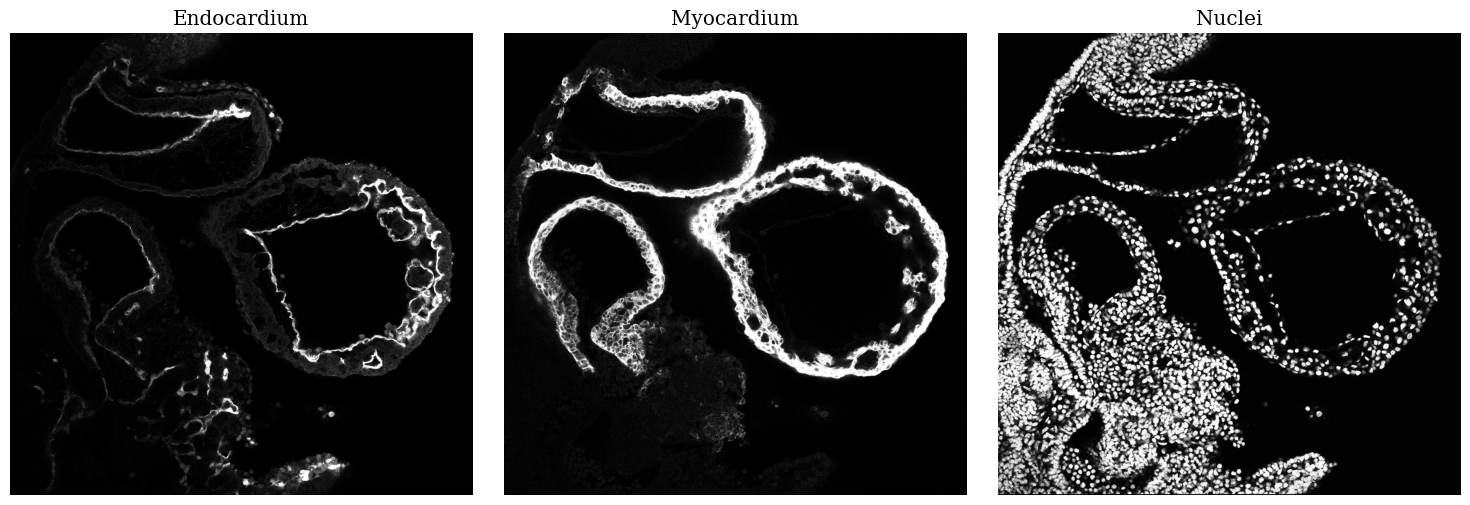

In [2]:
import nibabel as nib
import numpy as np

img1 = "/Users/dbattagodage/Desktop/Datasets/nnUnet_raw/Dataset352_IF_renamed_to_match_linux/imagesTr/IF_Tr_0002_0000.nii.gz"
img2 = "/Users/dbattagodage/Desktop/Datasets/nnUnet_raw/Dataset352_IF_renamed_to_match_linux/imagesTr/IF_Tr_0002_0001.nii.gz"
img3 = "/Users/dbattagodage/Desktop/Datasets/nnUnet_raw/Dataset352_IF_renamed_to_match_linux/imagesTr/IF_Tr_0002_0002.nii.gz"

img1 = nib.load(img1).get_fdata().astype(np.uint8)
img2 = nib.load(img2).get_fdata().astype(np.uint8)
img3 = nib.load(img3).get_fdata().astype(np.uint8)

middle_slice = img1.shape[2] // 2

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'DejaVu serif'
# rotate the images clockwise by 90 degrees for better visualization and flip vertically
img1 = np.rot90(img1, k=1, axes=(0, 1))
img2 = np.rot90(img2, k=1, axes=(0, 1))
img3 = np.rot90(img3, k=1, axes=(0, 1))
img1 = np.flipud(img1)
img2 = np.flipud(img2)
img3 = np.flipud(img3)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img1[:, :, middle_slice], cmap='gray')
axs[0].set_title('Endocardium')
axs[0].axis('off')  
axs[1].imshow(img2[:, :, middle_slice], cmap='gray')
axs[1].set_title('Myocardium')
axs[1].axis('off')
axs[2].imshow(img3[:, :, middle_slice], cmap='gray')
axs[2].set_title('Nuclei')
axs[2].axis('off')
plt.tight_layout()
fig.savefig('IF_Tr_0003_slices.pdf', dpi=300,bbox_inches='tight')
plt.show()

